### Fetching stock data

In [320]:
import yfinance as yf

# Create a Ticker object
msft = yf.Ticker("MSFT")

# Get historical data
hist_data = msft.history(period="max")

# Save to CSV
hist_data.to_csv("data/msft_history.csv")


### Lets analyse and clean the data

In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("data/msft_history.csv")
df = df[['Date', 'Close']]
df = df[8000:]



In [322]:
# Convert Date to date object
import datetime

def str_to_datetime(s):
  # Dont care about times after date
  s = s[:10]
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].apply(str_to_datetime)
df

,Date,Close
8000,2017-12-05,75.442657
8001,2017-12-06,76.542992
8002,2017-12-07,76.274841
8003,2017-12-08,77.819031
8004,2017-12-11,78.808403
...,...,...
9814,2025-02-25,397.899994
9815,2025-02-26,399.730011
9816,2025-02-27,392.529999
9817,2025-02-28,396.989990


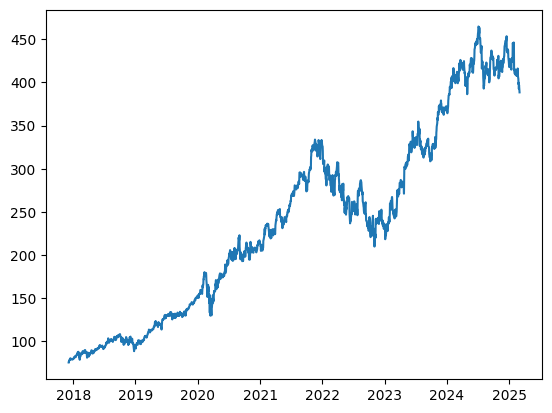

In [323]:
# Lets plot the stock data (date, price)
plt.plot(df['Date'], df['Close'])

In [324]:
# Lets create a timeseries dataset based on the data we have

def create_windowed_dataset(df, window_size=10, train_split=0.99):
    """
    Create sequences of length `window_size` to predict the close price on the next day.
    
    Parameters
    ----------
    df : pandas.DataFrame
        A DataFrame with at least two columns: 'Date' and 'Close'.
    window_size : int
        Number of past trading days to use as features.
    train_split : float
        Fraction of samples to include in the training set (0 < train_split < 1).
    
    Returns
    -------
    X_train : np.ndarray
        Training feature sequences of shape (num_train_samples, window_size).
    y_train : np.ndarray
        Training labels of shape (num_train_samples,).
    dates_train : np.ndarray
        Array of target-day dates for the training set (same length as y_train).
    X_test : np.ndarray
        Testing feature sequences of shape (num_test_samples, window_size).
    y_test : np.ndarray
        Testing labels of shape (num_test_samples,).
    dates_test : np.ndarray
        Array of target-day dates for the testing set (same length as y_test).
    """
    
    # Sort by date in case it's not sorted
    df = df.sort_values(by='Date').reset_index(drop=True)
    
    # Extract just the Close prices as a NumPy array
    prices = df['Close'].values
    dates = df['Date'].values
    
    X, y, y_dates = [], [], []
    
    # Start from `window_size` so we have `window_size` days prior
    for i in range(window_size, len(prices)):
        # Features: the previous `window_size` days
        X.append(prices[i-window_size:i])
        # Label: the price on the 'current' day
        y.append(prices[i])
        # Keep track of the date for the current (target) day
        y_dates.append(dates[i])
    
    X = np.array(X)
    y = np.array(y)
    y_dates = np.array(y_dates)
    
    # Train/test split by index
    train_size = int(len(X) * train_split)
    
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    dates_train, dates_test = y_dates[:train_size], y_dates[train_size:]
    
    return X_train, y_train, dates_train, X_test, y_test, dates_test

X_train, y_train, dates_train, X_test, y_test, dates_test = create_windowed_dataset(df, window_size=10, train_split=0.8)

# Last value in second training sample should be the first training sample label
assert X_train[1][9] == y_train[0]

# We have test data from a certain date until laste date in data

# Let us normalise the data with MinMaxScaler:

min_val = np.min(X_train)
max_val = np.max(X_train)

X_train = (X_train - min_val)/(max_val- min_val)
y_train = (y_train - min_val)/(max_val- min_val)

X_test = (X_test - min_val)/(max_val- min_val)
y_test = (y_test - min_val)/(max_val- min_val)





### Get the data into tensors and dataloaders

In [325]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# For demonstration, let's assume you already have your DataFrame `df`
# with columns: ['Date', 'Close'] (sorted by date).
# And you have a function that creates your windowed dataset:
# (X_train, y_train, _, X_test, y_test, _) = create_windowed_dataset(df)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32)


batch_size = 256
train_Dataset = TensorDataset(X_train, y_train)
test_Dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_Dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_Dataset, batch_size=batch_size, shuffle=False)

#### LSTM model

In [326]:
class LSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # batch_first=True => input/output shape = (batch, seq_len, features)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        
        # Initialize hidden state (h0) and cell state (c0) to zeros
        # shape = (num_layers, batch_size, hidden_dim)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # LSTM forward pass
        out, (hn, cn) = self.lstm(x, (h0, c0))  
        # out shape: (batch_size, seq_len, hidden_dim)
        
        # Take the output from the last time step
        out = out[:, -1, :]  # shape: (batch_size, hidden_dim)
        
        # Final fully connected layer => 1 output
        out = self.fc(out)   # shape: (batch_size, 1)
        
        return out


### Functions to train and evaluate

In [327]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        # Move to GPU if available
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        predictions = model(X_batch)
        # predictions shape: (batch_size, 1), y_batch shape: (batch_size,)
        loss = criterion(predictions.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(X_batch)
            loss = criterion(predictions.squeeze(), y_batch)
            total_loss += loss.item()
            
            # Save predictions and corresponding targets
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())
    
    # Concatenate all predictions and targets from batches
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    avg_loss = total_loss / len(val_loader)
    return avg_loss, all_predictions, all_targets



In [328]:
# Step 3: Instantiate model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(input_dim=1, hidden_dim=64, num_layers=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Step 4: Training loop
epochs = 350
for epoch in range(epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    test_loss, predictions, targets = evaluate_model(model, test_loader, criterion, device)
    targets = targets * (max_val - min_val) + min_val
    predictions = predictions * (max_val - min_val) + min_val
    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}  Test Loss: {test_loss:.4f}")




Epoch [1/350] - Train Loss: 0.3034  Test Loss: 1.3853
Epoch [2/350] - Train Loss: 0.2195  Test Loss: 1.1237
Epoch [3/350] - Train Loss: 0.1506  Test Loss: 0.8198
Epoch [4/350] - Train Loss: 0.0847  Test Loss: 0.4127
Epoch [5/350] - Train Loss: 0.0594  Test Loss: 0.1586
Epoch [6/350] - Train Loss: 0.0550  Test Loss: 0.2641
Epoch [7/350] - Train Loss: 0.0434  Test Loss: 0.2955
Epoch [8/350] - Train Loss: 0.0376  Test Loss: 0.1731
Epoch [9/350] - Train Loss: 0.0276  Test Loss: 0.0512
Epoch [10/350] - Train Loss: 0.0194  Test Loss: 0.0292
Epoch [11/350] - Train Loss: 0.0111  Test Loss: 0.0030
Epoch [12/350] - Train Loss: 0.0053  Test Loss: 0.0257
Epoch [13/350] - Train Loss: 0.0032  Test Loss: 0.0480
Epoch [14/350] - Train Loss: 0.0034  Test Loss: 0.0739
Epoch [15/350] - Train Loss: 0.0033  Test Loss: 0.0457
Epoch [16/350] - Train Loss: 0.0028  Test Loss: 0.0292
Epoch [17/350] - Train Loss: 0.0023  Test Loss: 0.0132
Epoch [18/350] - Train Loss: 0.0022  Test Loss: 0.0085
Epoch [19/350] - Tr

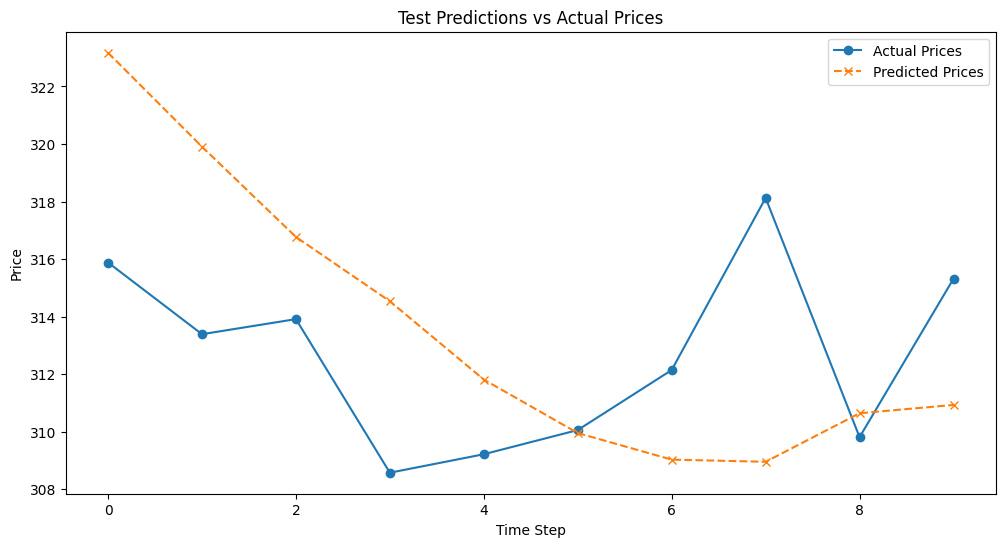

In [ ]:


plt.figure(figsize=(12, 6))
plt.plot(targets[10:40], label='Actual Prices', marker='o', linestyle='-')
plt.plot(predictions[10:40], label='Predicted Prices', marker='x', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.title('Test Predictions vs Actual Prices')
plt.legend()
plt.show()
print()

In [330]:
print(targets[targets.size-1])

print(X_train.shape)



388.49000420620723
torch.Size([1447, 10, 1])
